In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import csv_loader as loader
terrorism = loader.get_csv_file('terrorism')
world_population_2017 = loader.get_csv_file('world_population_2017')
pd.set_option('display.max_columns', None)


c:\Users\cyber\OneDrive\שולחן העבודה\analyst_project\Project\csv_loader.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['approxdate'] = pd.to_datetime(dict(year=dataframe['iyear'], month=dataframe['imonth'], day=dataframe['iday']))
c:\Users\cyber\OneDrive\שולחן העבודה\analyst_project\Project\csv_loader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.drop(columns=drop_columns, inplace=True)


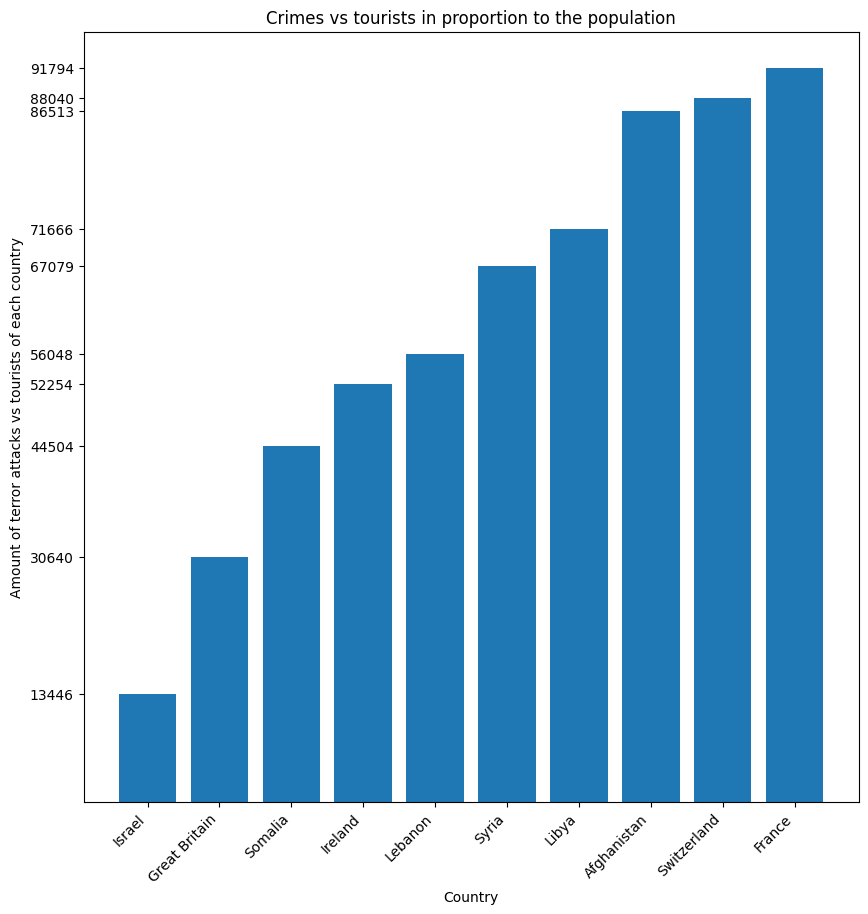

In [3]:
#Question #1- what country suffered from most terror attacks on her civilians when they were abroad in proportion to the population

#creating a new df 'new_db' where int_misc = 1 (int_misc is where people were attacked in a foreign country)
new_db = terrorism[terrorism['INT_MISC'] == 1]

#creating a new df named crime_vs_tourist that shows the amount of crimes vs tourists each country suffered, ignoring some irrelevant or misleading data 
crime_vs_tourist = new_db.groupby('natlty1_txt').size().reset_index(name='count')
crime_vs_tourist = crime_vs_tourist[crime_vs_tourist['natlty1_txt'].isin(['International', 'Multinational','West Bank and Gaza Strip']) == False]

# Adding counts for natlty2_txt and natlty3_txt - some attacks had few casualties, so nationality of every one in the attack, making sure the nationalities are only counted as 1
#example - 3 germans died - it'll only be counted as 1 and not +3 to germans
natlty2_counts = new_db[(new_db['natlty2_txt'] != new_db['natlty1_txt']) & (new_db['natlty2_txt'] != new_db['natlty3_txt'])].groupby('natlty2_txt').size().reset_index(name='count')
natlty3_counts = new_db[(new_db['natlty3_txt'] != new_db['natlty2_txt']) & (new_db['natlty3_txt'] != new_db['natlty1_txt'])].groupby('natlty3_txt').size().reset_index(name='count')


# Merging the counts of natlty2_txt and natlty3_txt with the main df
crime_vs_tourist = crime_vs_tourist.merge(natlty2_counts, left_on='natlty1_txt', right_on='natlty2_txt', how='left', suffixes=('', '_natlty2'))
crime_vs_tourist = crime_vs_tourist.merge(natlty3_counts, left_on='natlty1_txt', right_on='natlty3_txt', how='left', suffixes=('', '_natlty3'))
crime_vs_tourist['total_nationalities'] = crime_vs_tourist[['count', 'count_natlty2', 'count_natlty3']].sum(axis=1)

#new df vs_tourist_population - merged with a different db named 'world_population_2017' to get new df with population 
crime_vs_tourist_population = pd.merge(world_population_2017, crime_vs_tourist, left_on='Country_Name', right_on='natlty1_txt', how='inner')

#small modifications to df- making him more accurate and visually appealing and some minimum amount of attacks
crime_vs_tourist_population.rename(columns={'2017': 'population'}, inplace=True)
crime_vs_tourist_population = crime_vs_tourist_population.drop(columns=['natlty1_txt'])
crime_vs_tourist_population['population'] = crime_vs_tourist_population['population'].astype(int)
crime_vs_tourist_population = crime_vs_tourist_population[(crime_vs_tourist_population['total_nationalities'] > 70)]      
crime_vs_tourist_population.rename(columns={'count': 'nationality1'}, inplace=True)
crime_vs_tourist_population.rename(columns={'count_natlty2': 'nationality2'}, inplace=True)
crime_vs_tourist_population.rename(columns={'count_natlty3': 'nationality3'}, inplace=True)
crime_vs_tourist_population = crime_vs_tourist_population.drop(columns=['natlty2_txt'])
crime_vs_tourist_population = crime_vs_tourist_population.drop(columns=['natlty3_txt'])


#adding column to see attacks in proportion to the population, and sorting
crime_vs_tourist_population['proportion_of_population'] = crime_vs_tourist_population['population']/crime_vs_tourist_population['total_nationalities']
crime_vs_tourist_population.sort_values(by='proportion_of_population', ascending=True,inplace=True)
top_10_sorted = crime_vs_tourist_population.head(10)

#graph
plt.figure(figsize=(10, 10))
plt.bar(top_10_sorted['Country_Name'], top_10_sorted['proportion_of_population'])
plt.title('Crimes vs tourists in proportion to the population')
plt.xlabel('Country')
plt.ylabel('Amount of terror attacks vs tourists of each country')
plt.xticks(rotation=45, ha='right')
plt.yticks(top_10_sorted['proportion_of_population'])
plt.show()


#conclusion - 1 in every 13446 israelis will suffer a terror attack vs him when he will be abroad 
#top 5 - why (check what country mostly attacks froms)

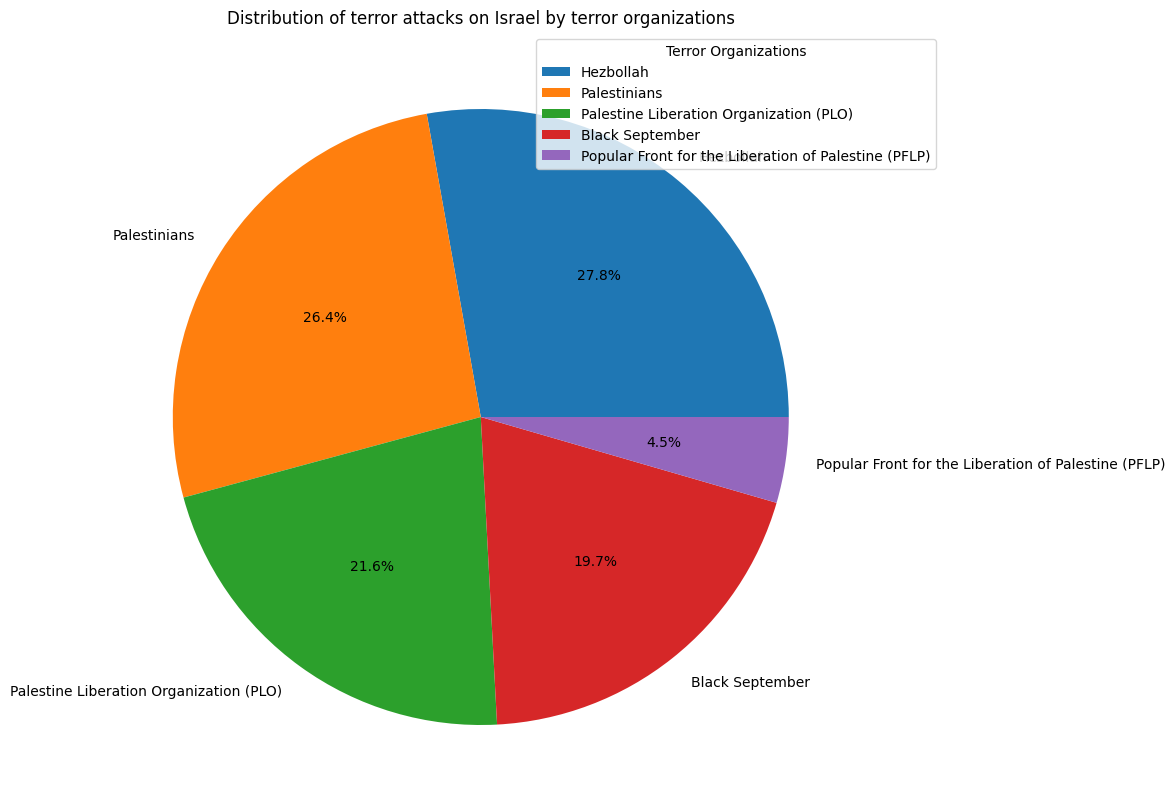

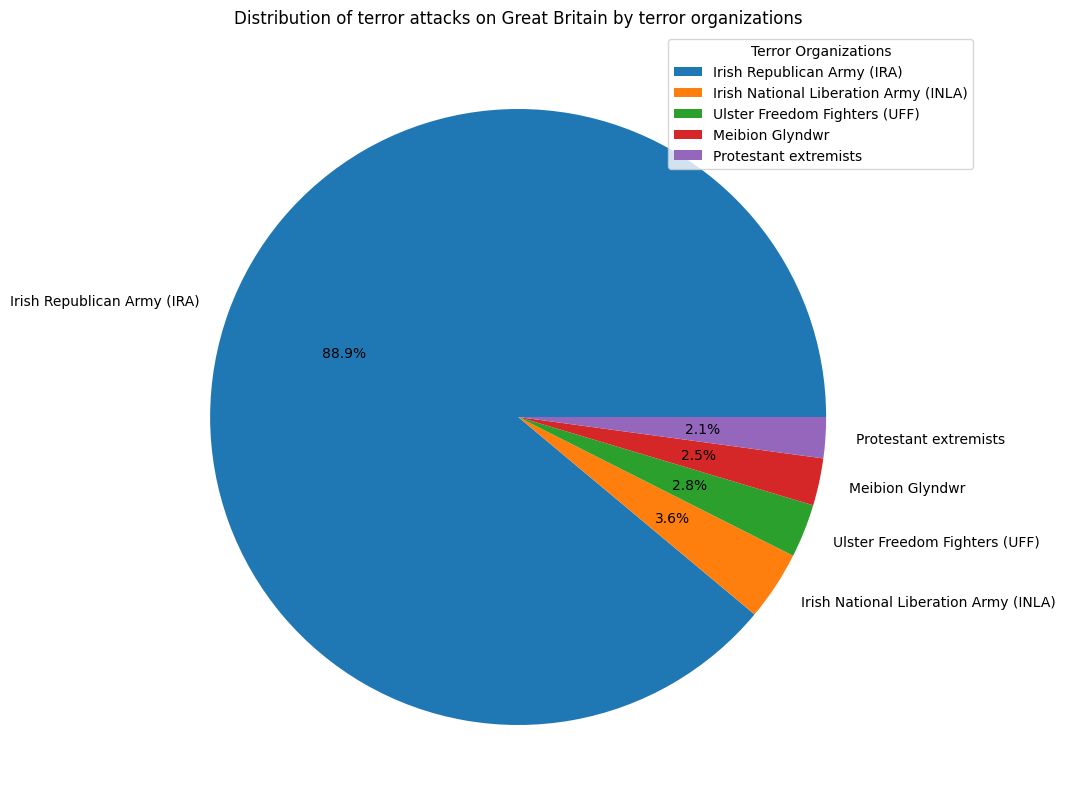

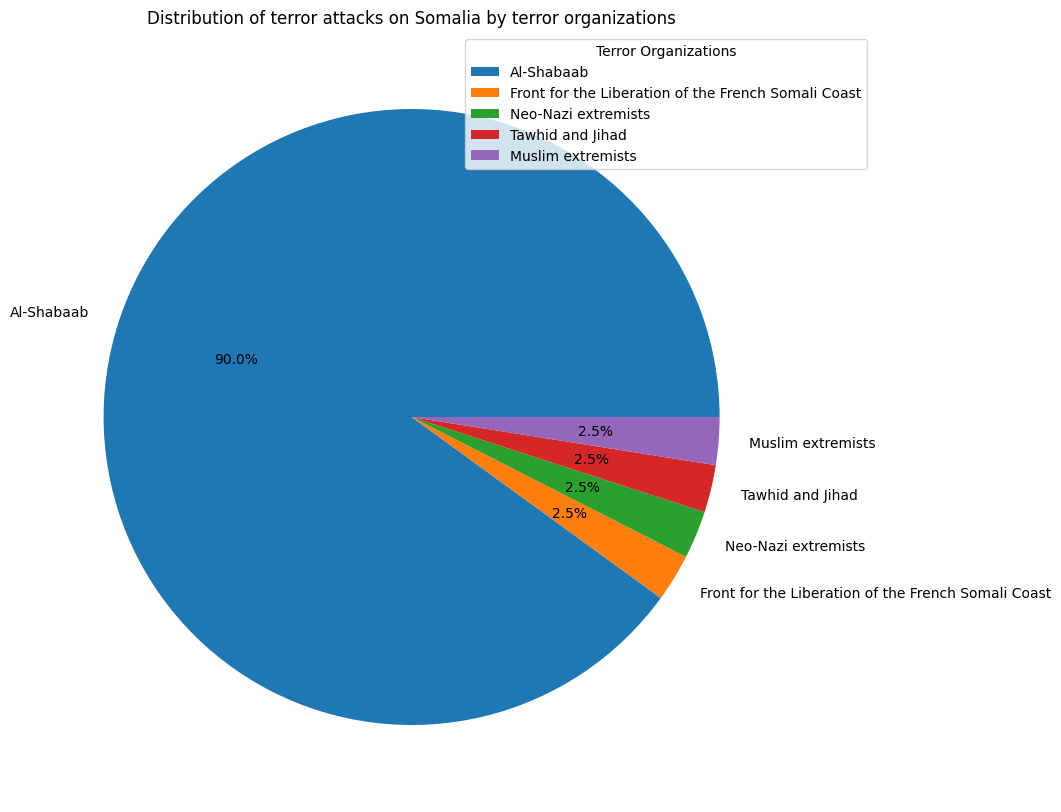

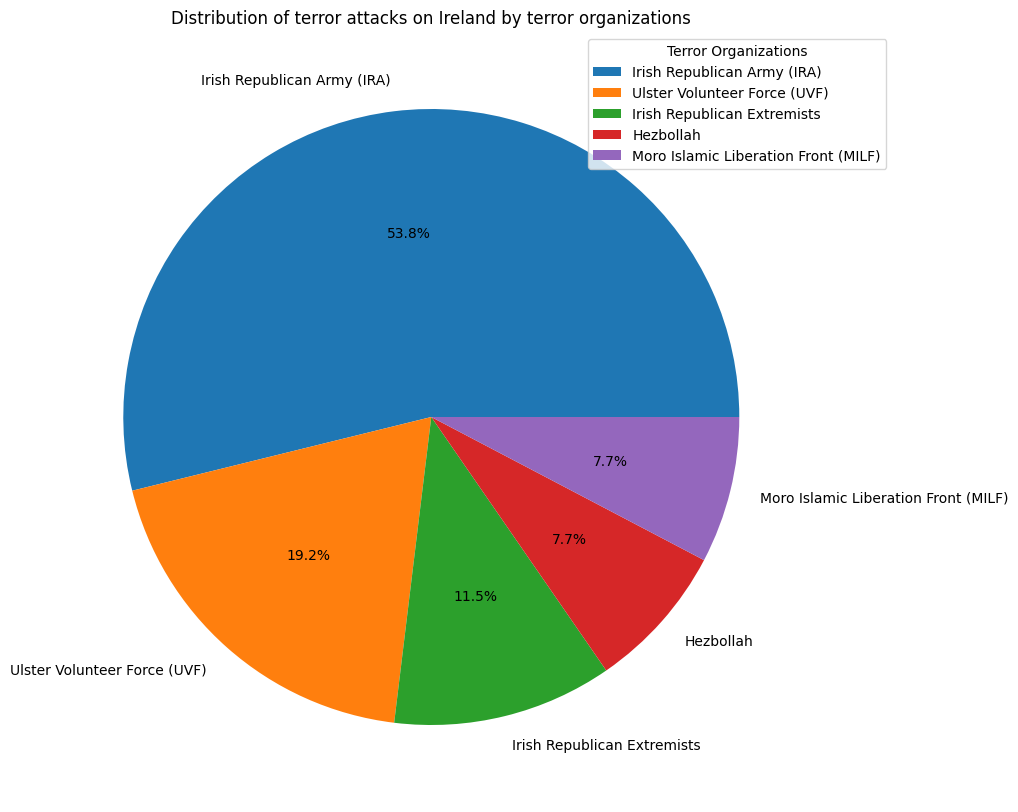

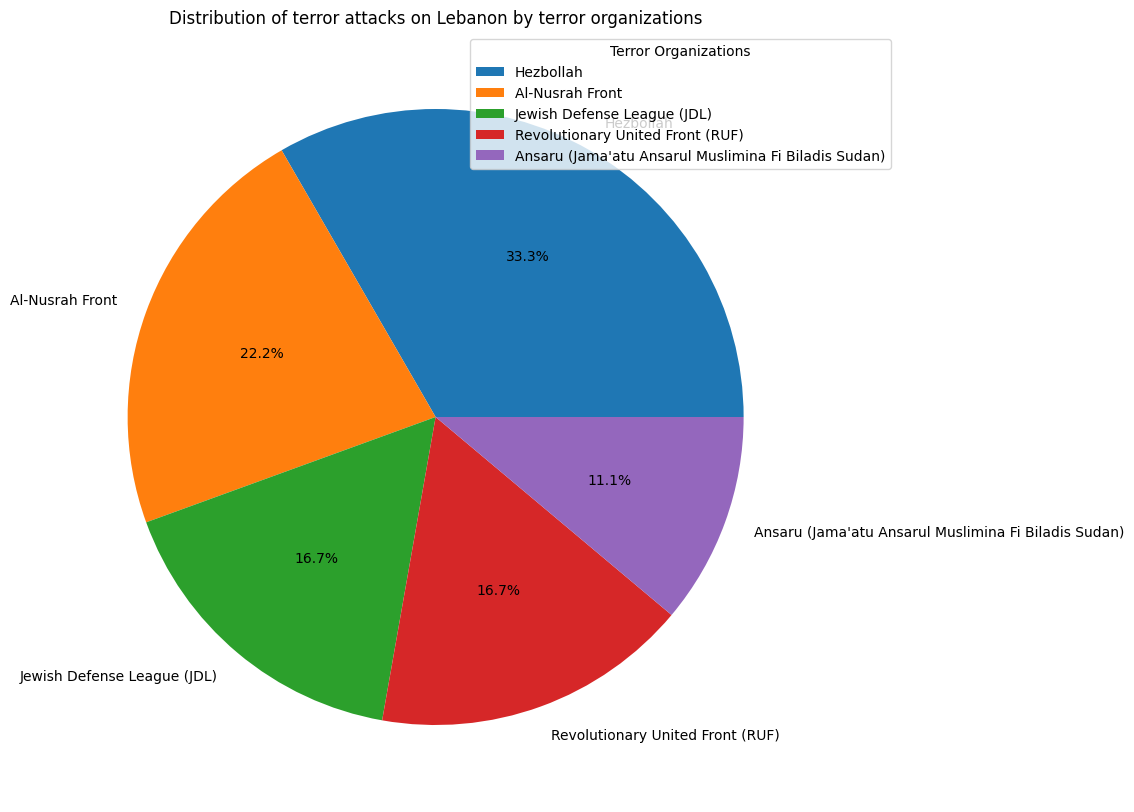

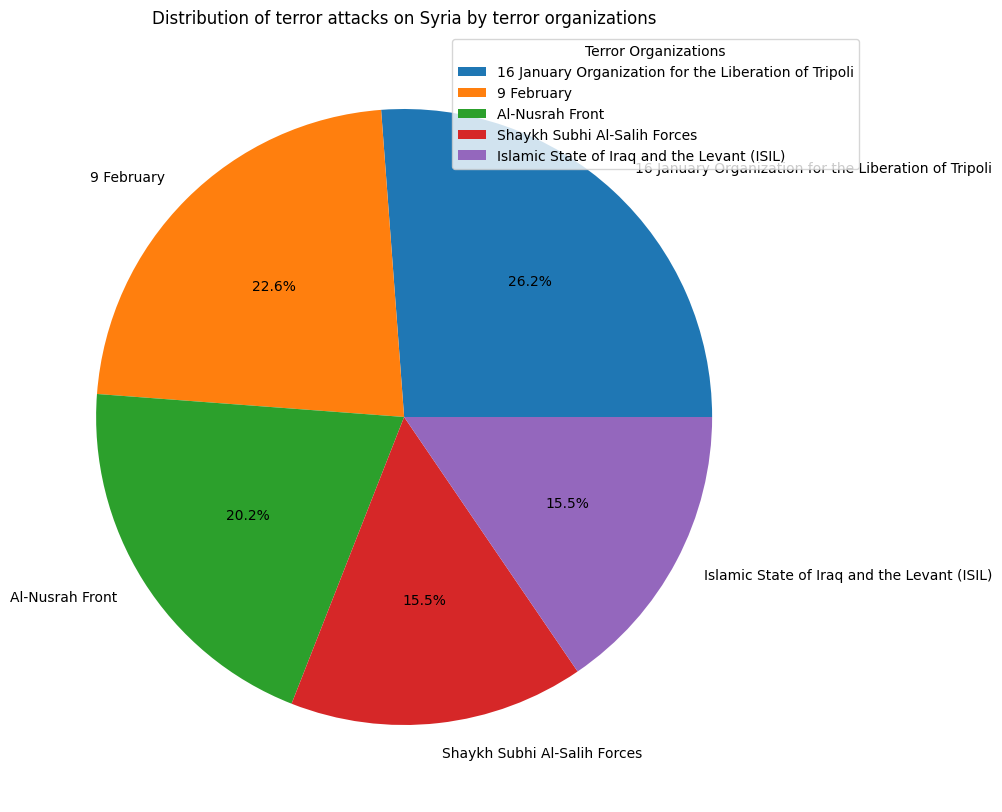

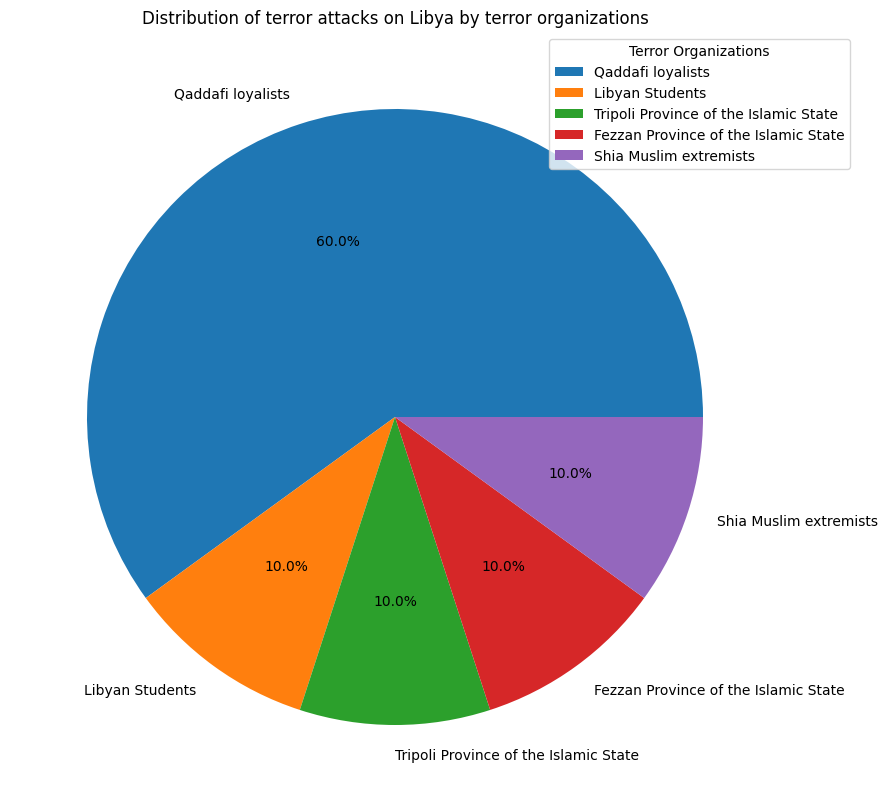

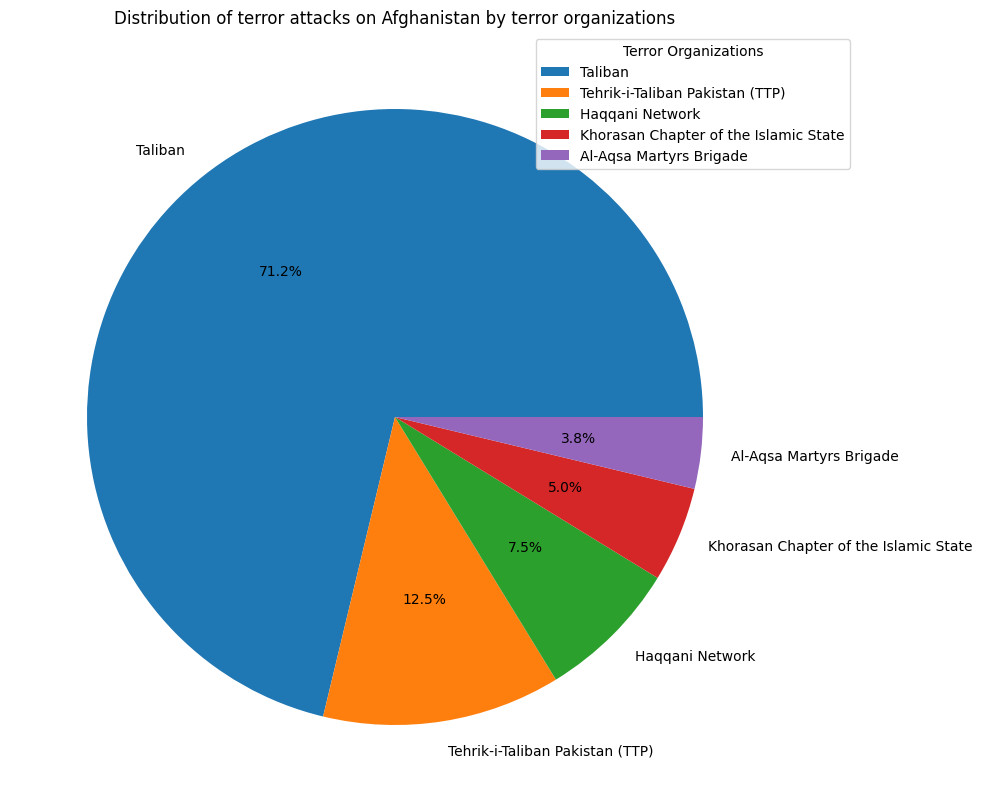

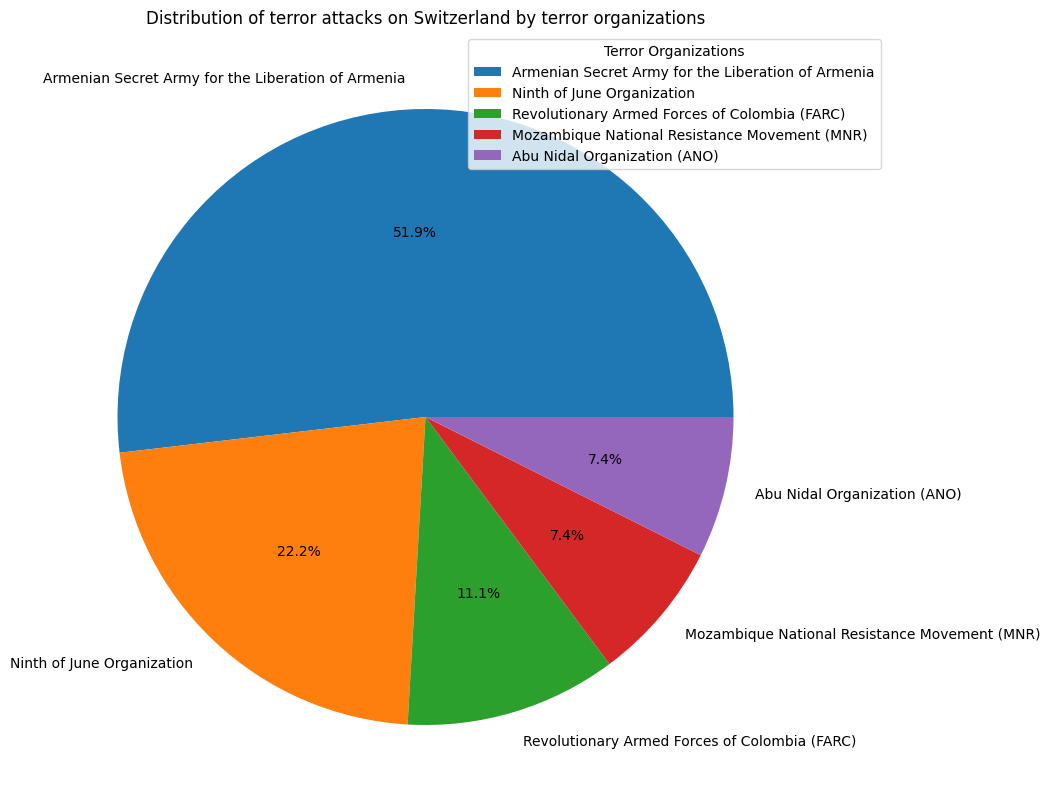

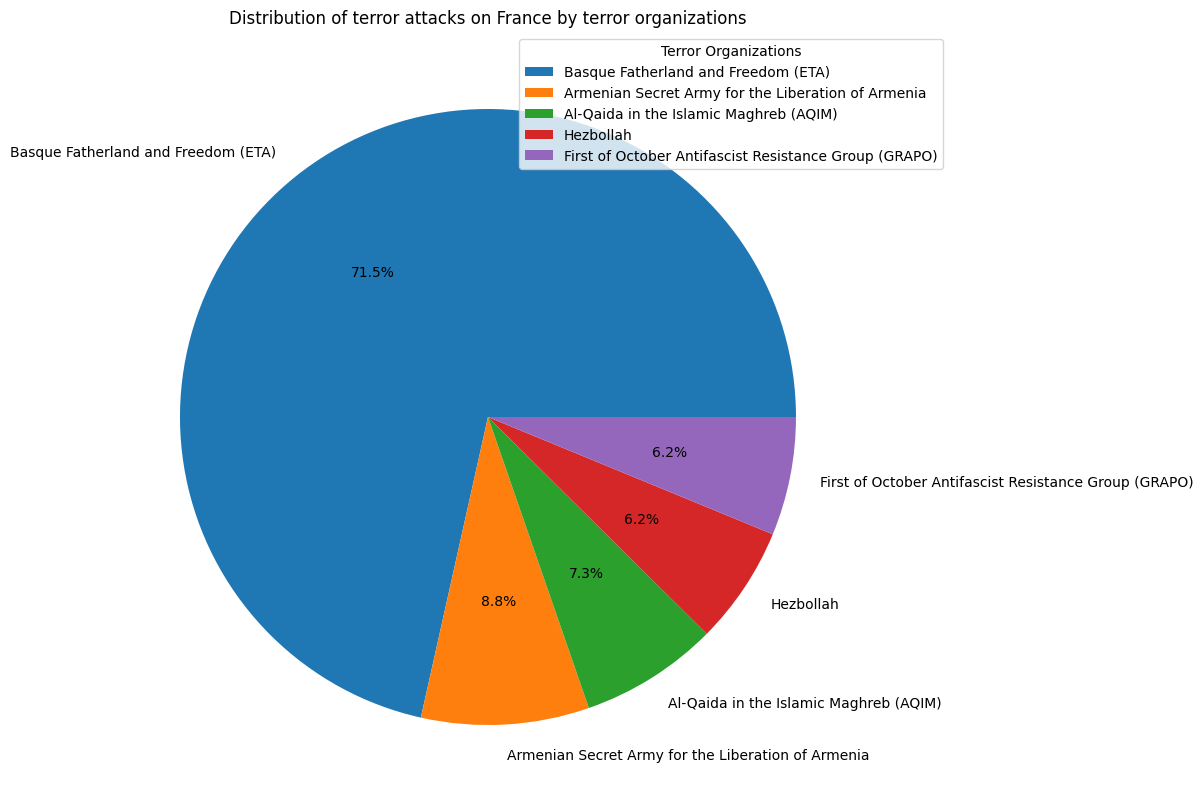

In [95]:
import matplotlib.pyplot as plt

for country in top_10_sorted['Country_Name']:
    # Extract relevant data for the current country
    country_db = terrorism[(terrorism['natlty1_txt'] == country) & (terrorism['INT_MISC'] == 1) & (terrorism['gname'] != 'Unknown')]  #####should we delete unknown or not

    # Combine data from all three columns and count occurrences
    all_gnames = country_db[['gname', 'gname2', 'gname3']].stack().reset_index(drop=True)
    gname_counts = all_gnames.value_counts().reset_index(name='count')

    # Select the top 5 terrorist organizations
    top_5_gnames = gname_counts.head(5)

    # Plotting the pie chart
    plt.figure(figsize=(10, 10))
    plt.pie(top_5_gnames['count'], autopct='%1.1f%%', labels=top_5_gnames['index'])
    plt.title(f'Distribution of terror attacks on {country} by terror organizations')
    plt.legend(title='Terror Organizations', loc='upper right', bbox_to_anchor=(1.1, 1))
    plt.show()
